In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# import warnings
# warnings.filterwarnings('ignore')

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# ****IMPORT NECESSARY LIBRARY****

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# ****READ CSV FILE****

In [5]:
df = pd.read_csv('Crop_recommendation.csv')

# ****Print the first five rows on the dataset****

In [6]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


# ****Print the information on the dataset to check missing value or etc.****

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


# ****Check the mean, median, and std of each column****

In [8]:
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


# ****Visualize numeric distribution using histplot****

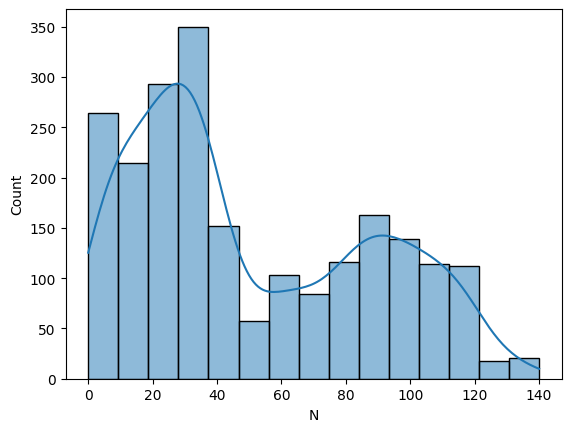

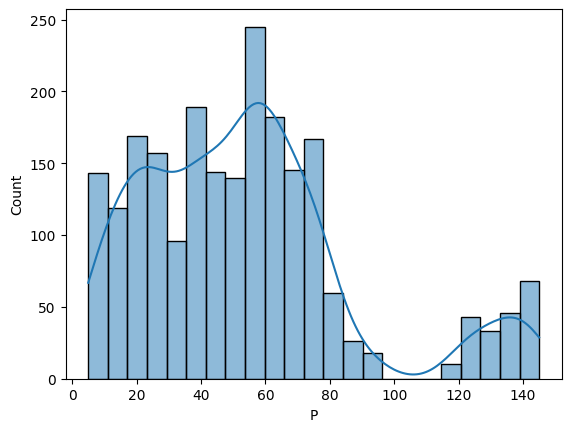

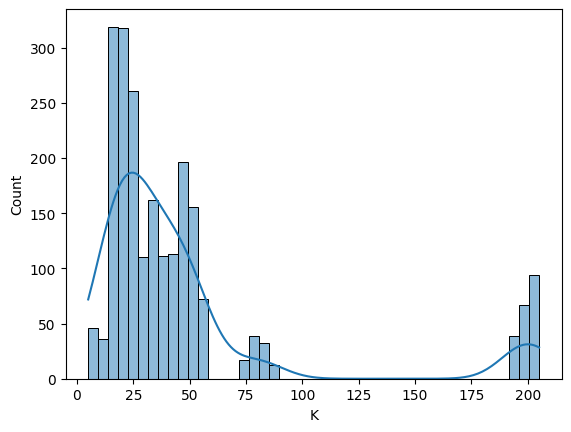

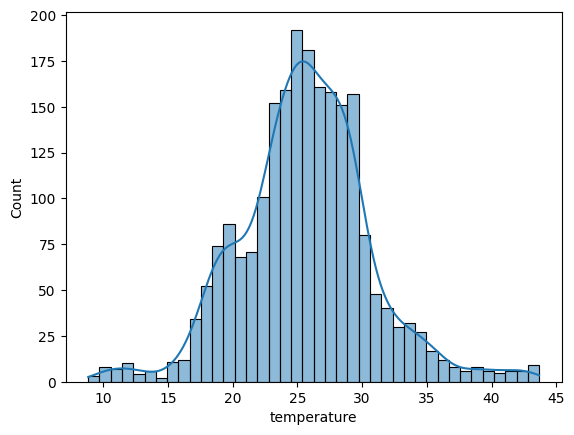

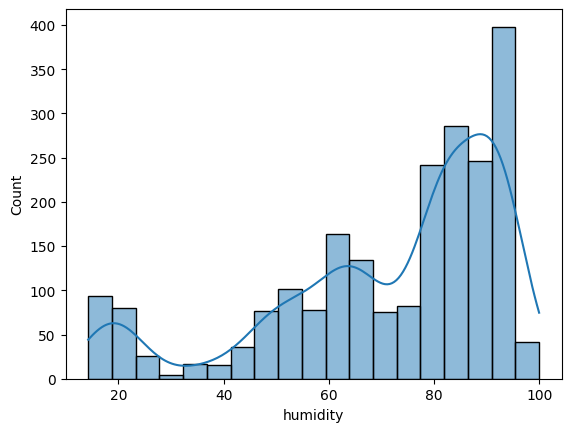

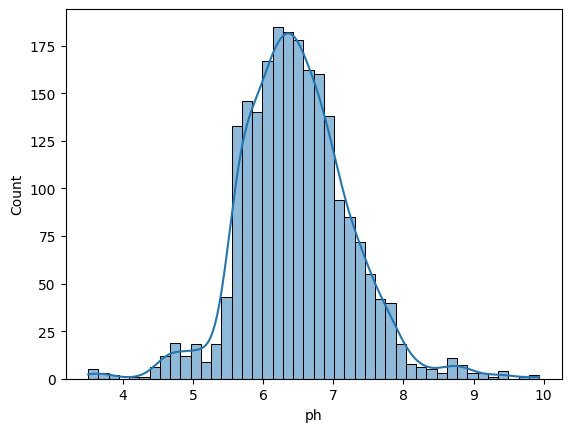

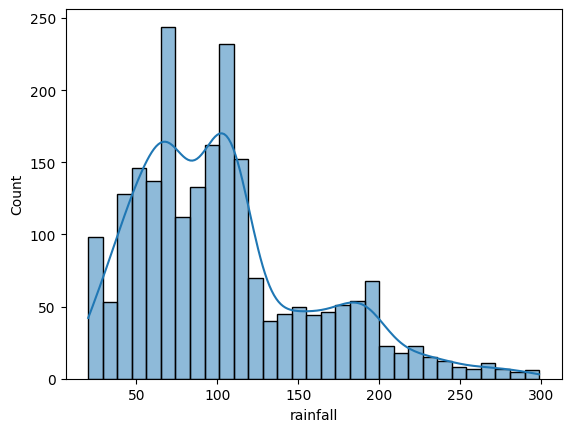

In [9]:
for num, i in enumerate(df.drop(columns='label', axis=1).columns):
    sns.histplot(df[i], kde=True)
    plt.show()

# ****Visulize Categorical distribution using pie chart****

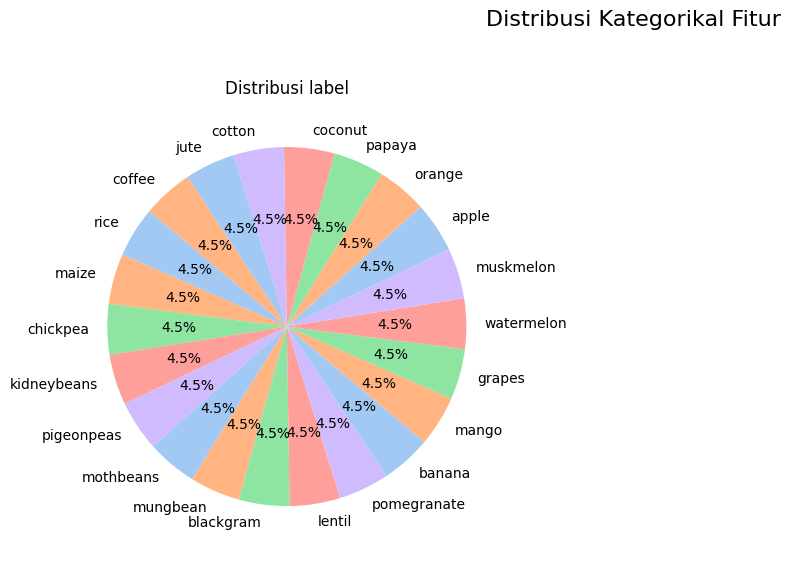

In [10]:
colors = sns.color_palette('pastel')[0:5]

plt.figure(figsize=(14, 10))

for i, feature in enumerate(['label'], 1):
    plt.subplot(2, 2, i)

    # Hitung frekuensi masing-masing kategori
    counts = df[feature].value_counts()

    # Buat pie chart
    plt.pie(
        counts,
        labels=counts.index,
        colors=colors,
        autopct='%1.1f%%',
        startangle=140
    )

    plt.title(f'Distribusi {feature}', fontsize=12)

plt.suptitle('Distribusi Kategorikal Fitur', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# ****Adding new features****

In [11]:
def feature_engineer(df):
    df['NPK'] = (df['N'] + df['P'] + df['K']) / 3
    df['THI'] = df['temperature'] * df['humidity'] / 100
    df['rainfall_level'] = pd.cut(df['rainfall'],
                              bins=[0, 50, 100, 200, 300],
                              labels=['Low', 'Medium', 'High', 'Very High'])
    def ph_category(p):
        if p < 5.5:
            return 'Acidic'
        elif p <= 7.5:
            return 'Neutral'
        else:
            return 'Alkaline'
    
    df['ph_category'] = df['ph'].apply(ph_category)
    df['temp_rain_interaction'] = df['temperature'] * df['rainfall']
    df['ph_rain_interaction'] = df['ph'] * df['rainfall']

    return df

In [12]:
df_fe = feature_engineer(df)
df_fe.head()

,N,P,K,temperature,humidity,ph,rainfall,label,NPK,THI,rainfall_level,ph_category,temp_rain_interaction,ph_rain_interaction
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,58.333333,17.121963,Very High,Neutral,4237.241986,1319.686807
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,61.333333,17.485957,Very High,Neutral,4934.395694,1595.223513
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,53.000000,18.937446,Very High,Alkaline,6072.354751,2069.534380
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,49.666667,21.234829,Very High,Neutral,6433.734530,1695.288324
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,54.000000,16.427204,Very High,Alkaline,5288.545993,2004.132110


# ****Convert ph_category from object to category type****

In [13]:
ph_order = CategoricalDtype(categories=["Acidic", "Neutral", "Alkaline"], ordered=True)

df_fe["ph_category"] = df_fe["ph_category"].astype(ph_order)

# ****Assign X and y values and encode target y using LabelEncoder****

In [14]:
X = df_fe.drop(columns='label', axis=1)
y = df_fe['label']
le_target = LabelEncoder()
y_enc = le_target.fit_transform(y)

#Split X and y_enc using train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y_enc, train_size=0.8, test_size=0.2, random_state=42, stratify=y_enc)

# ****Assingn num and cat cols****

In [15]:
num_cols = X.select_dtypes(include='number').columns
cat_cols = X.select_dtypes(include='category').columns

In [16]:
preprocess = ColumnTransformer([
    ('num', MinMaxScaler(), num_cols),
    ('cat', OrdinalEncoder(), cat_cols)
])

In [17]:
pipe = Pipeline([
    ('preprocess', preprocess),
    ('model', XGBClassifier(random_state=42))
])

In [18]:
fold = StratifiedKFold(n_splits=5, shuffle=True)
score = cross_val_score(pipe, X_train, y_train, cv=fold, scoring='accuracy')
for i, score in enumerate(score):
    print(f'fold {i + 1}: {(score * 100).round(2)}%')

fold 1: 99.15%
fold 2: 98.86%
fold 3: 97.73%
fold 4: 98.58%
fold 5: 98.58%


In [23]:
from sklearn.metrics import accuracy_score
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print(f'Accuracy: {(accuracy_score(y_pred, y_val) * 100).round(2)}%')

AttributeError: 'float' object has no attribute 'round'

# ****ADVANCED MODEL ANALYTICS****

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

# Generate detailed classification report
print("="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_val, y_pred, target_names=le_target.classes_))
print("\n")

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.95      0.97        20
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.95      1.00      0.98        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange       1.00      1.00      1.00        20
     

## Confusion Matrix Visualization

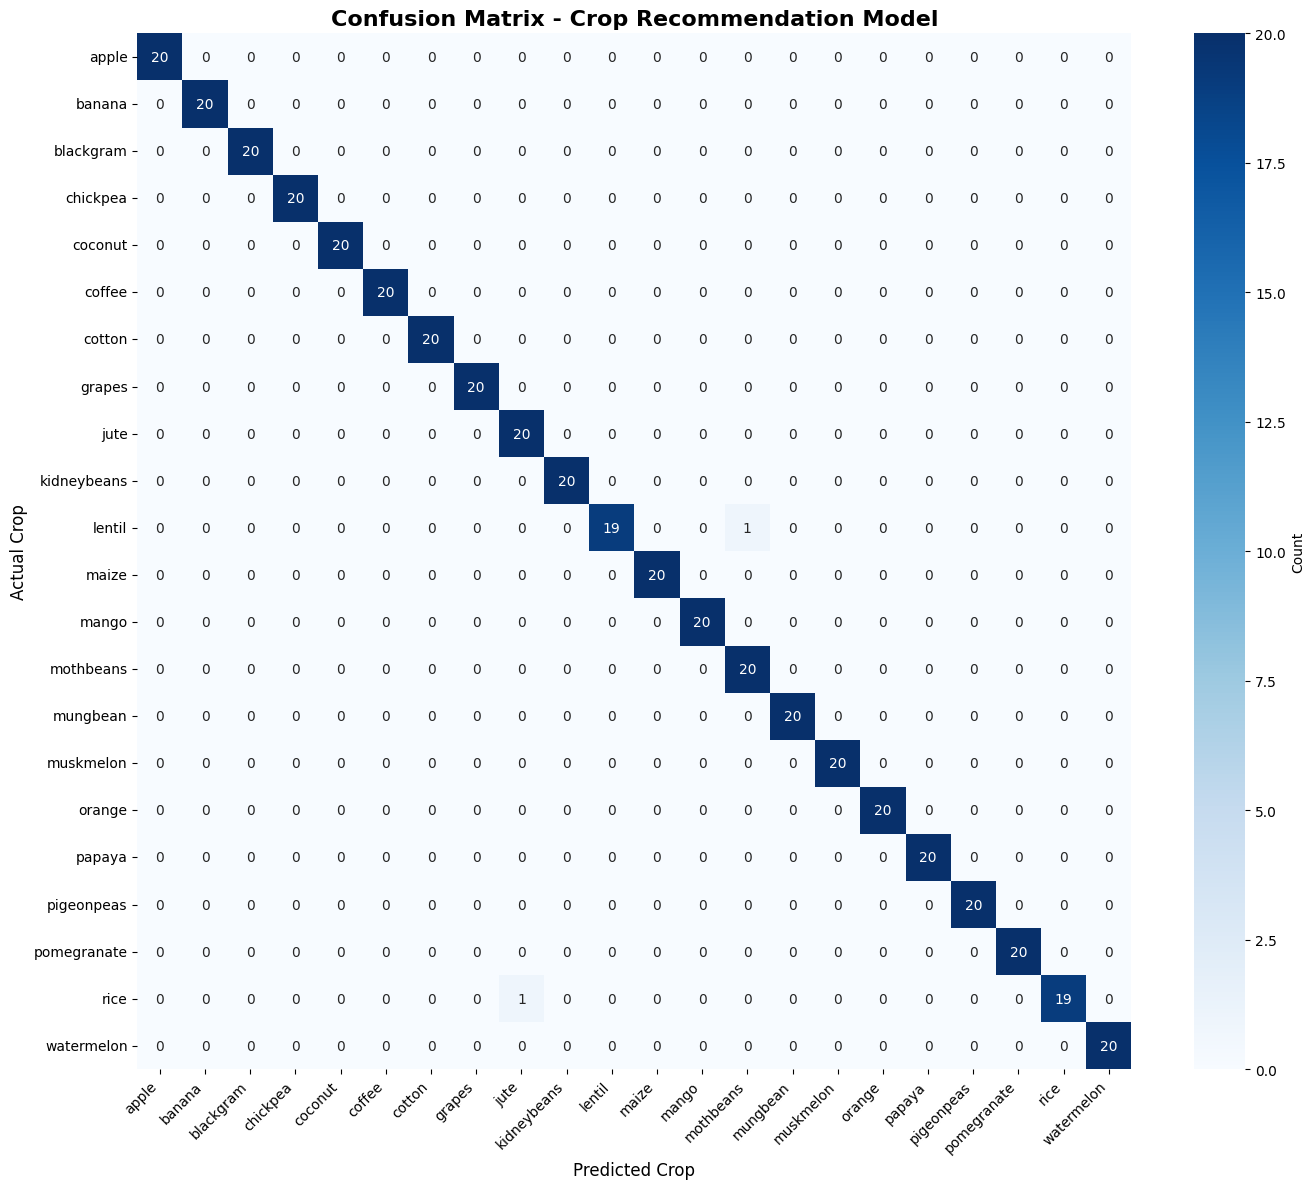

In [24]:
# Create confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_, 
            yticklabels=le_target.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Crop Recommendation Model', fontsize=16, fontweight='bold')
plt.ylabel('Actual Crop', fontsize=12)
plt.xlabel('Predicted Crop', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Per-Class Performance Metrics


Per-Class Performance Metrics:
       Crop  Precision  Recall  F1-Score  Support
      apple   1.000000    1.00  1.000000       20
     banana   1.000000    1.00  1.000000       20
  blackgram   1.000000    1.00  1.000000       20
   chickpea   1.000000    1.00  1.000000       20
    coconut   1.000000    1.00  1.000000       20
     coffee   1.000000    1.00  1.000000       20
     cotton   1.000000    1.00  1.000000       20
     grapes   1.000000    1.00  1.000000       20
kidneybeans   1.000000    1.00  1.000000       20
      maize   1.000000    1.00  1.000000       20
      mango   1.000000    1.00  1.000000       20
     orange   1.000000    1.00  1.000000       20
  muskmelon   1.000000    1.00  1.000000       20
   mungbean   1.000000    1.00  1.000000       20
 pigeonpeas   1.000000    1.00  1.000000       20
pomegranate   1.000000    1.00  1.000000       20
 watermelon   1.000000    1.00  1.000000       20
     papaya   1.000000    1.00  1.000000       20
       jute   0.95

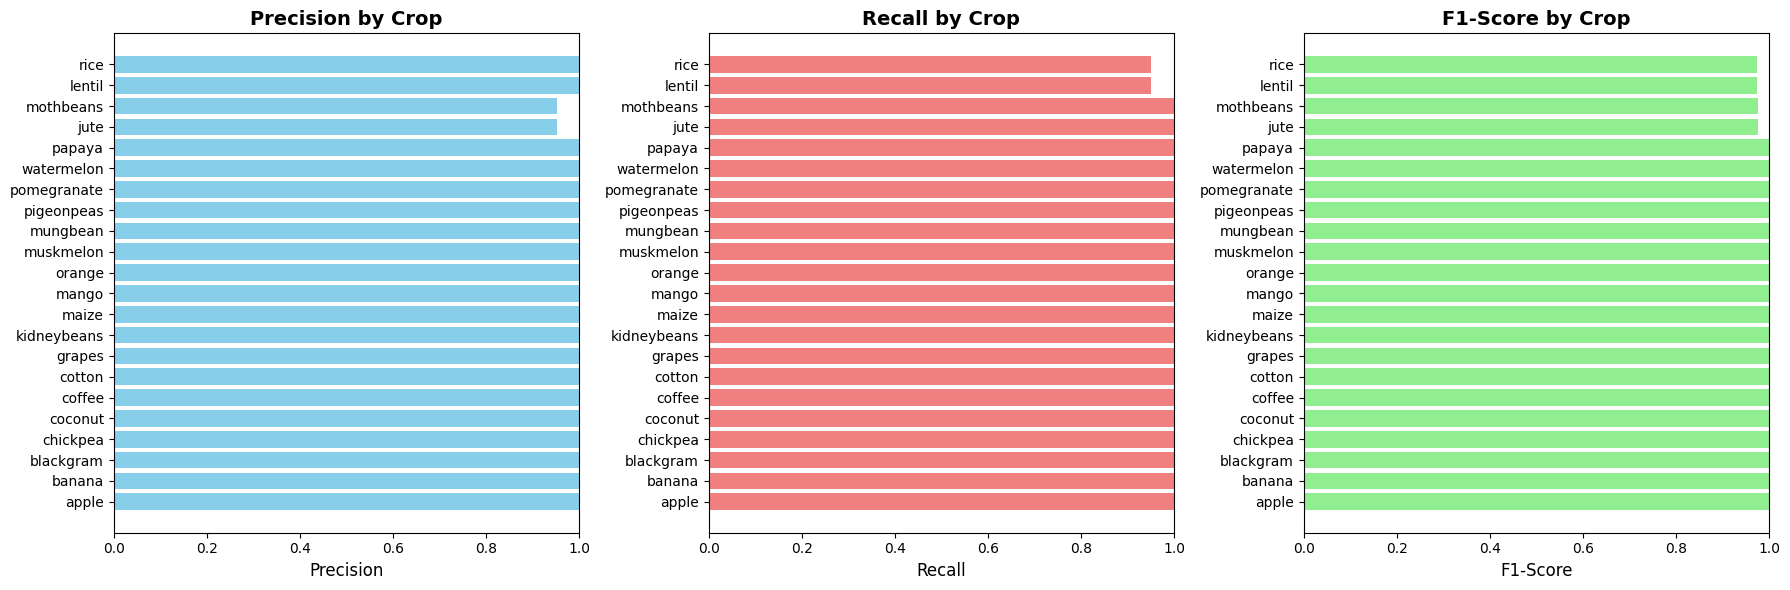

In [25]:
# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_val, y_pred)

# Create metrics dataframe
metrics_df = pd.DataFrame({
    'Crop': le_target.classes_,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
}).sort_values('F1-Score', ascending=False)

# Display metrics
print("\nPer-Class Performance Metrics:")
print(metrics_df.to_string(index=False))

# Visualize metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Precision
axes[0].barh(metrics_df['Crop'], metrics_df['Precision'], color='skyblue')
axes[0].set_xlabel('Precision', fontsize=12)
axes[0].set_title('Precision by Crop', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 1)

# Recall
axes[1].barh(metrics_df['Crop'], metrics_df['Recall'], color='lightcoral')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_title('Recall by Crop', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 1)

# F1-Score
axes[2].barh(metrics_df['Crop'], metrics_df['F1-Score'], color='lightgreen')
axes[2].set_xlabel('F1-Score', fontsize=12)
axes[2].set_title('F1-Score by Crop', fontsize=14, fontweight='bold')
axes[2].set_xlim(0, 1)

plt.tight_layout()
plt.show()

## Cross-Validation Scores Visualization

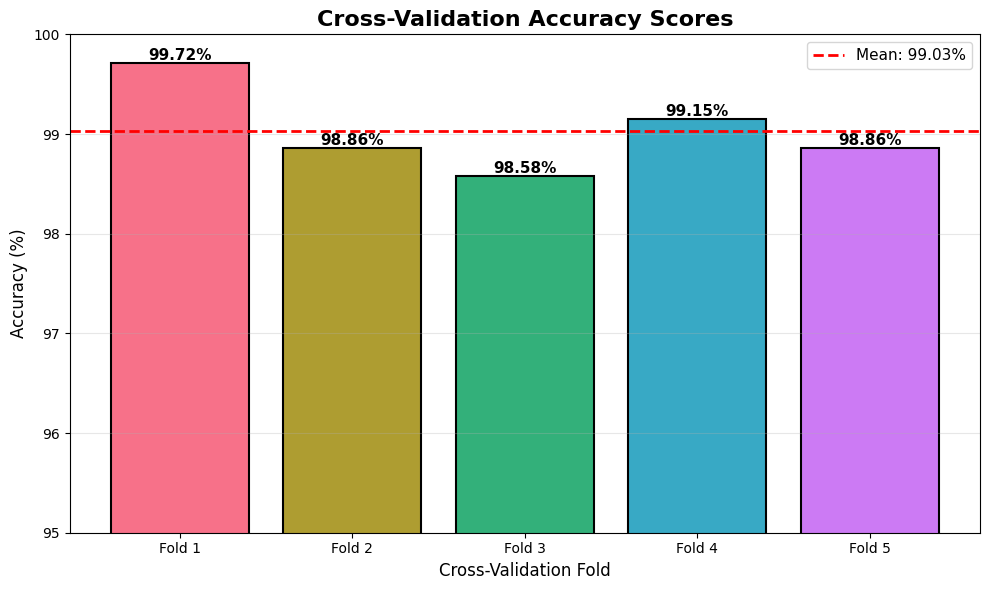


Cross-Validation Statistics:
Mean Accuracy: 99.03%
Standard Deviation: 0.39%


In [26]:
# Visualize cross-validation scores
fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=fold, scoring='accuracy')

plt.figure(figsize=(10, 6))
folds = [f'Fold {i+1}' for i in range(len(cv_scores))]
colors = sns.color_palette("husl", len(cv_scores))

bars = plt.bar(folds, cv_scores * 100, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add mean line
mean_score = cv_scores.mean() * 100
plt.axhline(y=mean_score, color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {mean_score:.2f}%')

plt.xlabel('Cross-Validation Fold', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Cross-Validation Accuracy Scores', fontsize=16, fontweight='bold')
plt.ylim(95, 100)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nCross-Validation Statistics:")
print(f"Mean Accuracy: {mean_score:.2f}%")
print(f"Standard Deviation: {(cv_scores.std() * 100):.2f}%")

In [27]:
importances = pipe.named_steps['model'].feature_importances_
feature_names = X_train.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

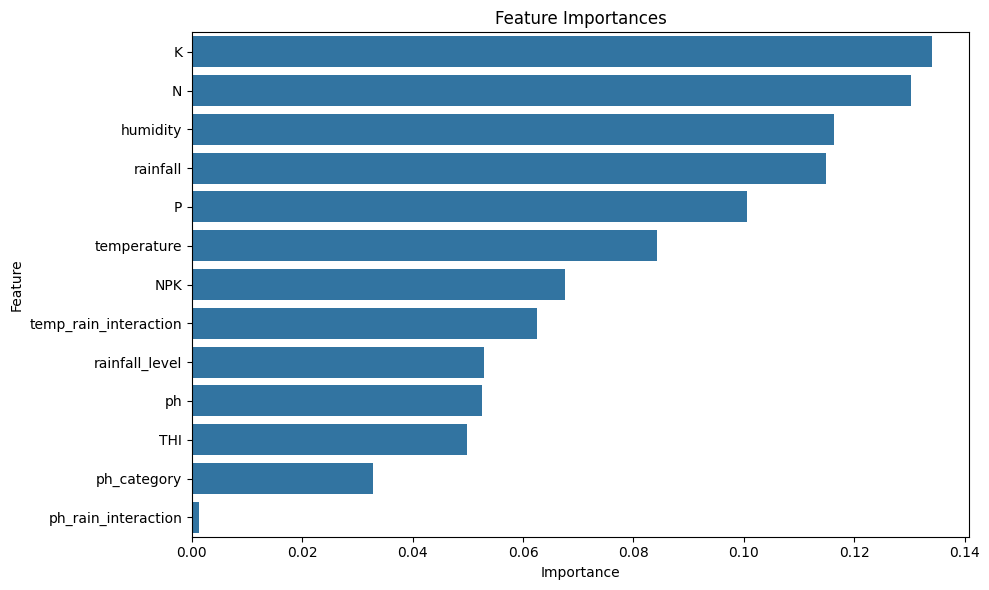

In [28]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [29]:
y_pred_inverse = le_target.inverse_transform(y_pred)
y_val_inverse = le_target.inverse_transform(y_val)
df_true = pd.DataFrame(y_val_inverse, columns=['TrueValue'])
df_pred = pd.DataFrame(y_pred_inverse, columns=['PredictedValue'])

In [30]:
compared_df = pd.concat([df_true, df_pred], axis=1)

In [31]:
compared_df.head(50)

,TrueValue,PredictedValue
0,orange,orange
1,banana,banana
2,cotton,cotton
3,maize,maize
4,orange,orange
5,chickpea,chickpea
6,rice,rice
7,blackgram,blackgram
8,banana,banana
9,orange,orange


# ****MODEL EXPORT FOR DEPLOYMENT****

## Save the trained model and preprocessing pipeline

In [32]:
import joblib
import json
from datetime import datetime

# Create a models directory if it doesn't exist
import os
if not os.path.exists('models'):
    os.makedirs('models')
    print("Created 'models' directory")

# Save the complete pipeline (includes preprocessing + model)
model_filename = 'models/crop_recommendation_model.pkl'
joblib.dump(pipe, model_filename)
print(f"✓ Model pipeline saved to: {model_filename}")

# Save the label encoder separately
encoder_filename = 'models/label_encoder.pkl'
joblib.dump(le_target, encoder_filename)
print(f"✓ Label encoder saved to: {encoder_filename}")

# Save model metadata
metadata = {
    'model_type': 'XGBoost Classifier',
    'accuracy': float(accuracy_score(y_pred, y_val)),
    'features': list(X.columns),
    'target_classes': list(le_target.classes_),
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'cv_mean_accuracy': float(cv_scores.mean()),
    'cv_std_accuracy': float(cv_scores.std()),
    'num_samples_train': len(X_train),
    'num_samples_val': len(X_val)
}

metadata_filename = 'models/model_metadata.json'
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"✓ Model metadata saved to: {metadata_filename}")

print("\n" + "="*60)
print("MODEL EXPORT SUMMARY")
print("="*60)
print(f"Model Accuracy: {metadata['accuracy']*100:.2f}%")
print(f"Cross-Validation Mean: {metadata['cv_mean_accuracy']*100:.2f}%")
print(f"Number of Features: {len(metadata['features'])}")
print(f"Number of Crop Classes: {len(metadata['target_classes'])}")
print(f"Training Samples: {metadata['num_samples_train']}")
print(f"Validation Samples: {metadata['num_samples_val']}")
print("="*60)

Created 'models' directory
✓ Model pipeline saved to: models/crop_recommendation_model.pkl
✓ Label encoder saved to: models/label_encoder.pkl
✓ Model metadata saved to: models/model_metadata.json

MODEL EXPORT SUMMARY
Model Accuracy: 99.55%
Cross-Validation Mean: 99.03%
Number of Features: 13
Number of Crop Classes: 22
Training Samples: 1760
Validation Samples: 440


## Test Loading and Using the Saved Model

In [33]:
# Load the saved model
loaded_model = joblib.load('models/crop_recommendation_model.pkl')
loaded_encoder = joblib.load('models/label_encoder.pkl')

print("✓ Model loaded successfully!")
print("\nTesting the loaded model with sample predictions...")

# Create sample input data for prediction
sample_data = pd.DataFrame({
    'N': [90, 40, 80],
    'P': [42, 40, 10],
    'K': [43, 60, 20],
    'temperature': [20.8, 27.5, 25.0],
    'humidity': [82.0, 80.0, 70.0],
    'ph': [6.5, 7.0, 6.0],
    'rainfall': [202.9, 100.5, 150.0]
})

# Apply the same feature engineering
sample_data_fe = feature_engineer(sample_data.copy())

print("\nSample Input Data:")
print(sample_data)

# Make predictions
predictions = loaded_model.predict(sample_data_fe)
predicted_crops = loaded_encoder.inverse_transform(predictions)

print("\nPredicted Crops:")
for i, crop in enumerate(predicted_crops):
    print(f"Sample {i+1}: {crop}")

# Get prediction probabilities
pred_proba = loaded_model.predict_proba(sample_data_fe)

print("\nTop 3 Predictions with Probabilities:")
for i in range(len(sample_data_fe)):
    print(f"\nSample {i+1}:")
    top_3_idx = pred_proba[i].argsort()[-3:][::-1]
    for idx in top_3_idx:
        crop_name = loaded_encoder.classes_[idx]
        probability = pred_proba[i][idx] * 100
        print(f"  {crop_name}: {probability:.2f}%")

✓ Model loaded successfully!

Testing the loaded model with sample predictions...

Sample Input Data:
    N   P   K  temperature  humidity   ph  rainfall
0  90  42  43         20.8      82.0  6.5     202.9
1  40  40  60         27.5      80.0  7.0     100.5
2  80  10  20         25.0      70.0  6.0     150.0

Predicted Crops:
Sample 1: rice
Sample 2: papaya
Sample 3: coffee

Top 3 Predictions with Probabilities:

Sample 1:
  rice: 99.63%
  jute: 0.14%
  coffee: 0.03%

Sample 2:
  papaya: 7.28%
  watermelon: 6.60%
  muskmelon: 6.18%

Sample 3:
  coffee: 70.15%
  maize: 27.56%
  jute: 1.50%


# ****DEPLOYMENT GUIDE FOR STREAMLIT/GRADIO****

## How to use this model in your web application

The model has been saved and can be easily integrated into Streamlit or Gradio apps. Below are example code snippets for both frameworks.

## Create Streamlit App (app.py)

In [ ]:
# Save this as a separate file: app_streamlit.py
streamlit_code = '''
import streamlit as st
import pandas as pd
import joblib
import numpy as np

# Feature engineering function
def feature_engineer(data):
    data['NPK'] = (data['N'] + data['P'] + data['K']) / 3
    data['THI'] = data['temperature'] * data['humidity'] / 100
    data['rainfall_level'] = pd.cut(data['rainfall'],
                              bins=[0, 50, 100, 200, 300],
                              labels=['Low', 'Medium', 'High', 'Very High'])
    def ph_category(p):
        if p < 5.5:
            return 'Acidic'
        elif p <= 7.5:
            return 'Neutral'
        else:
            return 'Alkaline'
    
    data['ph_category'] = data['ph'].apply(ph_category)
    data['temp_rain_interaction'] = data['temperature'] * data['rainfall']
    data['ph_rain_interaction'] = data['ph'] * data['rainfall']
    return data

# Load model
@st.cache_resource
def load_model():
    model = joblib.load('models/crop_recommendation_model.pkl')
    encoder = joblib.load('models/label_encoder.pkl')
    return model, encoder

model, encoder = load_model()

# App title
st.title('🌾 Crop Recommendation System')
st.write('Get AI-powered crop recommendations based on soil and climate conditions')

# Sidebar for input
st.sidebar.header('Enter Soil & Climate Parameters')

N = st.sidebar.slider('Nitrogen (N)', 0, 140, 90)
P = st.sidebar.slider('Phosphorus (P)', 5, 145, 42)
K = st.sidebar.slider('Potassium (K)', 5, 205, 43)
temperature = st.sidebar.slider('Temperature (°C)', 8.0, 44.0, 20.8)
humidity = st.sidebar.slider('Humidity (%)', 14.0, 100.0, 82.0)
ph = st.sidebar.slider('pH Level', 3.5, 9.9, 6.5)
rainfall = st.sidebar.slider('Rainfall (mm)', 20.0, 300.0, 202.9)

# Create input dataframe
input_data = pd.DataFrame({
    'N': [N], 'P': [P], 'K': [K],
    'temperature': [temperature],
    'humidity': [humidity],
    'ph': [ph],
    'rainfall': [rainfall]
})

# Apply feature engineering
input_data_fe = feature_engineer(input_data.copy())

# Predict button
if st.sidebar.button('Get Recommendation'):
    prediction = model.predict(input_data_fe)
    predicted_crop = encoder.inverse_transform(prediction)[0]
    
    # Get probabilities
    proba = model.predict_proba(input_data_fe)[0]
    top_3_idx = proba.argsort()[-3:][::-1]
    
    # Display results
    st.success(f'Recommended Crop: **{predicted_crop}**')
    
    st.subheader('Top 3 Recommendations:')
    for idx in top_3_idx:
        crop = encoder.classes_[idx]
        prob = proba[idx] * 100
        st.write(f'{crop}: {prob:.2f}%')
        st.progress(prob/100)

# Display input parameters
st.subheader('Input Parameters:')
st.write(input_data)
'''

# Save to file
with open('app_streamlit.py', 'w') as f:
    f.write(streamlit_code)

print("✓ Streamlit app code saved to: app_streamlit.py")
print("\nTo run the Streamlit app:")
print("  streamlit run app_streamlit.py")

## Create Gradio App (app_gradio.py)

In [ ]:
# Save this as a separate file: app_gradio.py
gradio_code = '''
import gradio as gr
import pandas as pd
import joblib

# Feature engineering function
def feature_engineer(data):
    data['NPK'] = (data['N'] + data['P'] + data['K']) / 3
    data['THI'] = data['temperature'] * data['humidity'] / 100
    data['rainfall_level'] = pd.cut(data['rainfall'],
                              bins=[0, 50, 100, 200, 300],
                              labels=['Low', 'Medium', 'High', 'Very High'])
    def ph_category(p):
        if p < 5.5:
            return 'Acidic'
        elif p <= 7.5:
            return 'Neutral'
        else:
            return 'Alkaline'
    
    data['ph_category'] = data['ph'].apply(ph_category)
    data['temp_rain_interaction'] = data['temperature'] * data['rainfall']
    data['ph_rain_interaction'] = data['ph'] * data['rainfall']
    return data

# Load model
model = joblib.load('models/crop_recommendation_model.pkl')
encoder = joblib.load('models/label_encoder.pkl')

def predict_crop(N, P, K, temperature, humidity, ph, rainfall):
    # Create input dataframe
    input_data = pd.DataFrame({
        'N': [N], 'P': [P], 'K': [K],
        'temperature': [temperature],
        'humidity': [humidity],
        'ph': [ph],
        'rainfall': [rainfall]
    })
    
    # Apply feature engineering
    input_data_fe = feature_engineer(input_data.copy())
    
    # Make prediction
    prediction = model.predict(input_data_fe)
    predicted_crop = encoder.inverse_transform(prediction)[0]
    
    # Get probabilities
    proba = model.predict_proba(input_data_fe)[0]
    top_3_idx = proba.argsort()[-3:][::-1]
    
    # Format results
    result = f"**Recommended Crop:** {predicted_crop}\\n\\n**Top 3 Recommendations:**\\n"
    for idx in top_3_idx:
        crop = encoder.classes_[idx]
        prob = proba[idx] * 100
        result += f"- {crop}: {prob:.2f}%\\n"
    
    return result

# Create Gradio interface
demo = gr.Interface(
    fn=predict_crop,
    inputs=[
        gr.Slider(0, 140, value=90, label="Nitrogen (N)"),
        gr.Slider(5, 145, value=42, label="Phosphorus (P)"),
        gr.Slider(5, 205, value=43, label="Potassium (K)"),
        gr.Slider(8.0, 44.0, value=20.8, label="Temperature (°C)"),
        gr.Slider(14.0, 100.0, value=82.0, label="Humidity (%)"),
        gr.Slider(3.5, 9.9, value=6.5, label="pH Level"),
        gr.Slider(20.0, 300.0, value=202.9, label="Rainfall (mm)")
    ],
    outputs=gr.Markdown(),
    title="🌾 Crop Recommendation System",
    description="Get AI-powered crop recommendations based on soil and climate conditions",
    examples=[
        [90, 42, 43, 20.8, 82.0, 6.5, 202.9],
        [40, 40, 60, 27.5, 80.0, 7.0, 100.5],
        [80, 10, 20, 25.0, 70.0, 6.0, 150.0]
    ]
)

if __name__ == "__main__":
    demo.launch()
'''

# Save to file
with open('app_gradio.py', 'w') as f:
    f.write(gradio_code)

print("✓ Gradio app code saved to: app_gradio.py")
print("\nTo run the Gradio app:")
print("  python app_gradio.py")

## Requirements File for Deployment

In [ ]:
# Create requirements.txt for deployment
requirements = '''pandas>=1.3.0
numpy>=1.21.0
scikit-learn>=1.0.0
xgboost>=1.5.0
joblib>=1.1.0
streamlit>=1.20.0
gradio>=3.20.0
matplotlib>=3.4.0
seaborn>=0.11.0
'''

with open('requirements.txt', 'w') as f:
    f.write(requirements)

print("✓ Requirements file saved to: requirements.txt")
print("\nTo install dependencies:")
print("  pip install -r requirements.txt")

## 📋 Deployment Instructions

### For Streamlit:
1. Install dependencies: `pip install -r requirements.txt`
2. Run the app: `streamlit run app_streamlit.py`
3. Open browser at: `http://localhost:8501`

### For Gradio:
1. Install dependencies: `pip install -r requirements.txt`
2. Run the app: `python app_gradio.py`
3. Open the local URL shown in terminal

### Files Required for Deployment:
- `models/crop_recommendation_model.pkl` - Trained model pipeline
- `models/label_encoder.pkl` - Label encoder
- `models/model_metadata.json` - Model information
- `app_streamlit.py` or `app_gradio.py` - Web application
- `requirements.txt` - Python dependencies

### Note:
Make sure the `models` folder is in the same directory as your app file!